# Hyper

A script to detect the most hyped (popular) bands of a festival

In [1]:
# https://www.dataquest.io/blog/python-pandas-databases/

In [44]:
import sqlite3
import pandas as pd
import string
import unicodedata
import numpy as np

## Load Data

In [184]:
# Setup sqlite
sqlite_file = 'hyper.db'

# Connect to the database sqlite file
connection = sqlite3.connect(sqlite_file)
db = connection.cursor()

In [239]:
# get list of bands from db
bands = pd.read_sql_query("SELECT * FROM Bands;", connection)
print("{} bands read".format(len(bands)))
#bands.head()

268 bands read


In [240]:
# read ALL tweets from db
all_tweets = pd.read_sql_query("SELECT * FROM TweetsRaw", connection)
print("{} tweets in db".format(len(all_tweets)))

1105 tweets in db


In [241]:
# read ONLY tweets that have to be processed
tweets_to_process = pd.read_sql_query("SELECT * FROM TweetsRaw WHERE processed IS NULL", connection)
print("{} tweets to be processed".format(len(tweets_to_process)))

1055 tweets to be processed


In [211]:
# read ONLY tweets that have to be processed
#tweets_to_process = pd.read_sql_query("SELECT tr.* FROM TweetsRaw AS tr \
#                                       LEFT JOIN BandTweets AS bt ON tr.id == bt.tweetRawId \
#                                       WHERE bt.tweetRawId IS NULL", connection)
#print("{} tweets to process".format(len(tweets_to_process)))

In [212]:
# tweets_to_process = tweets_to_process.head(50)
# print("{} tweets to process (!!!REMOVE!!!)".format(len(tweets_to_process)))

50 tweets to process (!!!REMOVE!!!)


## Partition per band

Look for tweets talking about bands and re-create data structure in a band-centered way

In [51]:
def extract_bands(tweet):
    """
    Function that extracts the bands from a tweet text
    Returns a list of bands
    """
    
    # init list to return
    bands_in_tweet = []
    
    # loop all bands and check of any of the written forms is present in the tweet text
    for i, b in bands.iterrows():
                
        # set different band names writing possibilities
        bandname = b['name']
        bandname_lowercase = bandname.lower()
        bandname_lowercase_no_spaces = ''.join(bandname_lowercase.split())
        bandname_lowercase_no_accents = ''.join((c for c in unicodedata.normalize('NFD', bandname_lowercase) if unicodedata.category(c) != 'Mn'))
        bandname_lowercase_no_spaces_no_accents = ''.join((c for c in unicodedata.normalize('NFD', bandname_lowercase_no_spaces) if unicodedata.category(c) != 'Mn'))

        # check if any of the forms is in the tweet text
        if any(s in tweet['tweetText'].lower() for s in [bandname_lowercase, bandname_lowercase_no_spaces, bandname_lowercase_no_accents, bandname_lowercase_no_spaces_no_accents, b['twitterName']]):
            bands_in_tweet.append({"id": b['id'], "codedName": b['codedName']})

    return bands_in_tweet

In [52]:
def band_partition(tweet):
    """
    Function that reads a single tweet info and adds into a list the tweet information partitioned by bands.
    I.e. If a tweet mentions 2 bands, it adds a list of 2 dicts with the tweet info
    """
    
    # loop all bands and add an entry to the list
    for b in tweet['bands']:
        new_band_tweets_list.append({\
                                 "tweetRawId" : tweet['id'],\
                                 "createdAt" : tweet['createdAt'],\
                                 "storedAt" : tweet['storedAt'],\
                                 "bandId" : b['id'],\
                                 "bandCodedName" : b['codedName'],\
                                 "favsCount" : tweet['favsCount'],\
                                 "rtsCount" : tweet['rtsCount'],\
                                 "language" : tweet['language'],\
                                 "userId" : tweet['userId'],\
                                 "userFriendsCount" : tweet['userFriendsCount'],\
                                 "userFollowersCount" : tweet['userFollowersCount'],\
                                 "userStatusesCount" : tweet['userStatusesCount'],\
                                 "userFavsCount" : tweet['userFavsCount'],\
                                 "userLocation" : tweet['userLocation']\
                                })
    
    # Mark TweetsRaw as processed
    db.execute("UPDATE TweetsRaw SET processed = 1 WHERE id == {}".format(tweet.id))
    connection.commit()

In [242]:
if(tweets_to_process.shape[0] > 0):

    # extract bands for each tweet
    tweets_to_process['bands'] = tweets_to_process.apply(extract_bands, axis=1)

    # construct the list of tweets per band
    new_band_tweets_list = []
    tweets_to_process.apply(band_partition, axis=1);

    # create a dataframe from the previous list
    new_band_tweets = pd.DataFrame.from_dict(new_band_tweets_list)
    print("{} band-tweets".format(new_band_tweets.shape[0]))
else:
    new_band_tweets = pd.DataFrame([])
    print("No new tweets to process")

264 band-tweets


In [243]:
# Persist extracted tweets in DB (BandTweets table)
if(new_band_tweets.shape[0] > 0):
    new_band_tweets[['tweetRawId', 'bandId']].to_sql('BandTweets', connection, if_exists='append')
    print("{} new band tweets persisted".format(new_band_tweets.shape[0]))
else:
    print("No new band tweets to persist")

264 new band tweets persisted


## Explore Band-Tweet Data

In [244]:
# Construct a dataframe joining data from TweetsRaw and BandTweets
band_tweets = pd.read_sql_query("SELECT bt.bandId, \
                                        b.name AS bandName, \
                                        b.codedName AS bandCodedName, \
                                        b.headLevel AS headLevel, \
                                        tr.* \
                                 FROM BandTweets AS bt\
                                 LEFT JOIN TweetsRaw AS tr ON bt.tweetRawId == tr.id \
                                 LEFT JOIN Bands AS b ON bt.bandId == b.id", connection)
print("{} band tweets in db".format(band_tweets.shape[0]))

277 band tweets in db


In [245]:
# Count tweets per band
print(band_tweets.groupby('bandCodedName').size().sort_values(ascending=False))

bandCodedName
arcadefire            16
frankocean            15
belako                15
tie                   13
thecrabapples         12
keems                 11
glassanimals          11
!!!                   10
pond                   9
pavvla                 8
solange                7
slayer                 7
macdemarco             7
museless               6
barbott                6
thewavepictures        5
gas                    5
grandaddy              5
clubz                  4
mishima                3
fufanu                 3
polseguera             3
shellac                3
runthejewels           3
theharlock             3
kinggizzard            3
formation              2
ferenc                 2
elzasoares             2
front242               2
                      ..
martadelmont           1
vanmorrison            1
skinnypuppy            1
aphextwin              1
kink                   1
alientango             1
alexandrasavior        1
aldrinycollins         1
tycho      

In [246]:
# Count measures of a given band
bandCodedName = 'thewavepictures'
print("Tweets about {}:  {}".format(bandCodedName,band_tweets.groupby('bandCodedName').size()[bandCodedName]))
print("Total Favs of {}: {}".format(bandCodedName,band_tweets.groupby('bandCodedName').sum()['favsCount'][bandCodedName]))
print("Total RTs of {}:  {}".format(bandCodedName,band_tweets.groupby('bandCodedName').sum()['rtsCount'][bandCodedName]))

Tweets about thewavepictures:  5
Total Favs of thewavepictures: 10
Total RTs of thewavepictures:  0


## Explore Band-Tweet Timelines

In [247]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

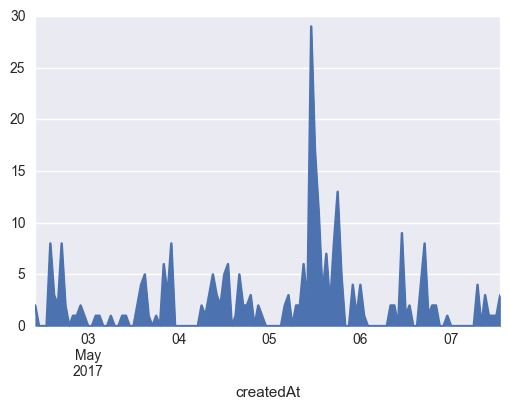

In [248]:
# timeline of tweets - all bands
# https://chrisalbon.com/python/pandas_group_data_by_time.html
band_tweets['createdAt'] = pd.to_datetime(band_tweets['createdAt'], format ='%a %b %d %H:%M:%S +0000 %Y')
band_tweets.index = band_tweets['createdAt']
band_tweets.resample('H').count()['bandId'].plot(kind='area')

/Users/eduard/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


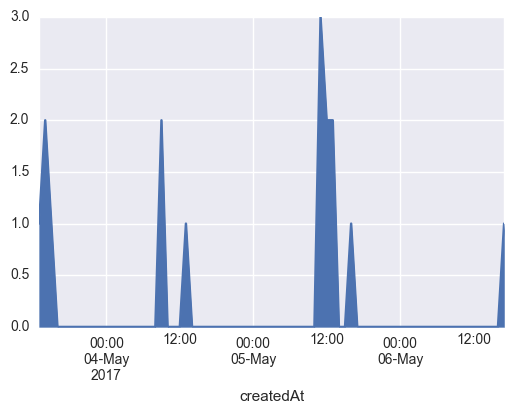

In [249]:
# timeline of tweets - single band
bandCodedName = 'arcadefire'
single_band_tweets = band_tweets[band_tweets['bandCodedName'] == bandCodedName]
single_band_tweets['createdAt'] = pd.to_datetime(single_band_tweets['createdAt'], format ='%a %b %d %H:%M:%S +0000 %Y')
single_band_tweets.index = single_band_tweets['createdAt']
single_band_tweets.resample('H').count()['bandId'].plot(kind='area')

## Hyper Score & Ranking

Create the dataframe with one row per band and all the metrics associated

In [250]:
# group and sum band tweets by band
band_hypes = band_tweets.groupby(['bandCodedName', 'bandName', 'bandId', 'headLevel']).sum()

# insert a column with the number of tweets
band_hypes['tweets'] = band_tweets.groupby(['bandCodedName', 'bandName', 'bandId', 'headLevel']).size()

# reset the index created in the group by
band_hypes = band_hypes.reset_index()

# delete not needed columns
del band_hypes['id']
del band_hypes['userFriendsCount']
del band_hypes['userFollowersCount']
del band_hypes['userStatusesCount']
del band_hypes['userFavsCount']
del band_hypes['processed']

# rename and re-order columns
band_hypes = band_hypes.rename(columns={'favsCount':'favs', 'rtsCount':'retweets'})
band_hypes = band_hypes[['bandId', 'bandCodedName', 'bandName', 'headLevel', 'tweets', 'favs', 'retweets']]

### TF-IDF revisited
- term => band
- document => all tweets
- corpus of documents => X

#### TF: Term Frequency (normalized)
Definition:
- Measures how frequently a term occurs in a document
- Measures how frequently a band is mentioned in a set of tweets

Computation:
- number of times term t appears in a document) / total number of terms in the document
- number of tweets talking about that band / total number of tweets

#### IDF: Inverse Document Frequency
Definition:
- Measures how important a term
- Measures how important a band is

Computation:
- log( total number of documents / number of documents with term t in it)
- we don't have other documents so we need another way to measure how important a band is...
  - we will consider the level of headliner of the band (according to the font size used in the festival lineup poster)
  - 5 levels: 1 (top line-up) to 5 (bottom line-up)

In [293]:
# Compute BF-IHL (Band Frequency - Inverse Headline Level)
bf_numerator = band_hypes['tweets']*(band_hypes['favs'] + band_hypes['retweets'])
band_hypes['bf-ihl'] = (bf_numerator/bf_numerator.sum()) * np.log(band_hypes['headLevel'].astype(float) + 1)

#
# TODO: how do we normalize BF? total number of band_tweets? or distinct band_tweets?
#

In [294]:
# band_hypes.sort_values(by='tweets', ascending=False).head(10)
band_hypes.sort_values(by='bf-ihl', ascending=False).head(10)

,bandId,bandCodedName,bandName,headLevel,tweets,favs,retweets,bf-ihl
33,75,grandaddy,Grandaddy,3,5,1,236,0.249659
40,100,keems,Keems,4,11,20,40,0.161433
82,265,tie,Tiê,5,13,3,39,0.148678
8,21,arcadefire,Arcade Fire,1,16,44,31,0.126410
77,43,thecrabapples,The Crab Apples,4,12,14,24,0.111536
11,28,belako,Belako,3,15,9,24,0.104288
61,167,pond,Pond,3,9,8,35,0.081534
31,70,glassanimals,Glass Animals,3,11,14,20,0.078795
10,27,barbott,Barbott,4,6,0,36,0.052833
58,158,pavvla,PAVVLA,4,8,3,21,0.046962


In [ ]:
#
#
# Persist band_hypes to DB
#
#